In [63]:
# Install necessary libraries
!pip install pandas numpy matplotlib seaborn scikit-learn statsmodels xgboost lightgbm tensorflow imbalanced-learn scipy

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Preprocessing & Validation
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from imblearn.over_sampling import SMOTE

# Enhanced Metrics
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    recall_score, precision_score, f1_score, confusion_matrix,
    classification_report, mean_absolute_percentage_error
)

# Statistical Tests
from scipy.stats import ttest_ind, wilcoxon
from statsmodels.tsa.stattools import adfuller, acf, pacf

# Models
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Set Seeds
np.random.seed(42)
tf.random.set_seed(42)

print("✅ All libraries loaded successfully!")

✅ All libraries loaded successfully!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Found file at: /content/drive/My Drive/airquality.zip
 Extraction complete.
Processing Delhi Data...


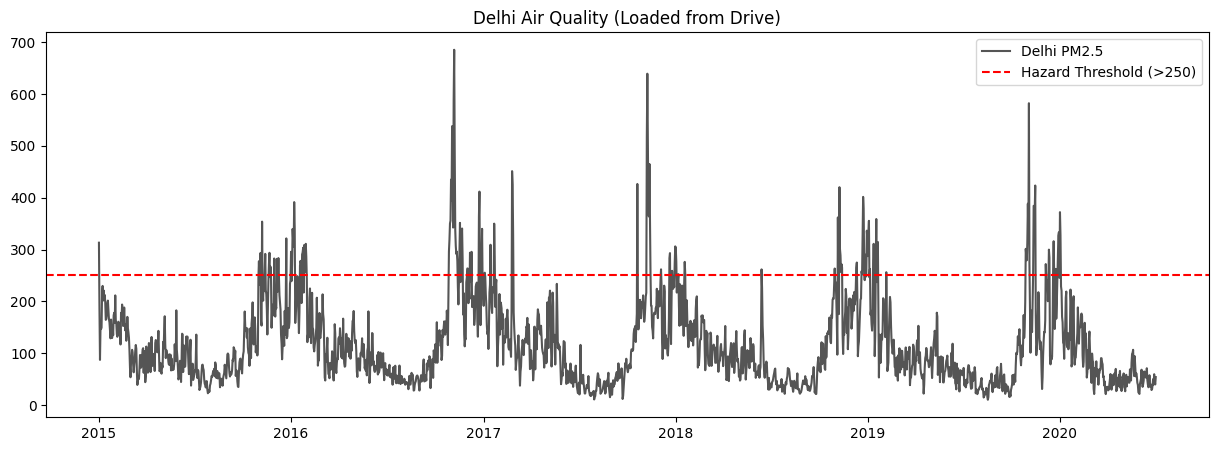

 SUCCESS: Dataset ready with 2009 days of data.


In [64]:
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/drive')

zip_path = '/content/drive/My Drive/airquality.zip'

# 3. Unzip the file
if os.path.exists(zip_path):
    print(f" Found file at: {zip_path}")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('/content/aq_data')
    print(" Extraction complete.")
else:
    print(f"ERROR: Could not find file at {zip_path}")
    print("Please check if the file is in the root of 'My Drive' or inside a folder.")

# 4. Load the 'city_day.csv' file
csv_path = None
for root, dirs, files in os.walk('/content/aq_data'):
    for file in files:
        if file == 'city_day.csv':
            csv_path = os.path.join(root, file)

if csv_path:
    # 5. Filter for DELHI and Preprocess
    print("Processing Delhi Data...")
    raw_df = pd.read_csv(csv_path)
    df = raw_df[raw_df['City'] == 'Delhi'].copy()

    # Date conversion & Sorting
    df['Date'] = pd.to_datetime(df['Date'])
    df = df[['Date', 'PM2.5']].sort_values('Date')

    # Interpolation (Fill gaps linearly)
    df['PM2.5'] = df['PM2.5'].interpolate(method='linear', limit_direction='both')

    # 6. Visualize to Confirm
    plt.figure(figsize=(15, 5))
    plt.plot(df['Date'], df['PM2.5'], label='Delhi PM2.5', color='#555555')
    plt.axhline(y=250, color='red', linestyle='--', label='Hazard Threshold (>250)')
    plt.title("Delhi Air Quality (Loaded from Drive)")
    plt.legend()
    plt.show()

    print(f" SUCCESS: Dataset ready with {len(df)} days of data.")
else:
    print(" ERROR: Could not find 'city_day.csv' inside the zip file.")

In [65]:
def create_advanced_features(data, lags=[1, 2, 3, 7, 14]):
    """Enhanced feature engineering with more features"""
    df_feat = data.copy()

    # A. Lag Features
    for lag in lags:
        df_feat[f'lag_{lag}'] = df_feat['PM2.5'].shift(lag)

    # B. Rolling Statistics (Multiple windows)
    for window in [3, 7, 14, 30]:
        df_feat[f'rolling_mean_{window}'] = df_feat['PM2.5'].shift(1).rolling(window=window).mean()
        df_feat[f'rolling_std_{window}'] = df_feat['PM2.5'].shift(1).rolling(window=window).std()
        df_feat[f'rolling_min_{window}'] = df_feat['PM2.5'].shift(1).rolling(window=window).min()
        df_feat[f'rolling_max_{window}'] = df_feat['PM2.5'].shift(1).rolling(window=window).max()

    # C. Cyclical Time Features
    df_feat['sin_month'] = np.sin(2 * np.pi * df_feat['Date'].dt.month / 12)
    df_feat['cos_month'] = np.cos(2 * np.pi * df_feat['Date'].dt.month / 12)
    df_feat['sin_day'] = np.sin(2 * np.pi * df_feat['Date'].dt.dayofweek / 7)
    df_feat['cos_day'] = np.cos(2 * np.pi * df_feat['Date'].dt.dayofweek / 7)
    df_feat['sin_doy'] = np.sin(2 * np.pi * df_feat['Date'].dt.dayofyear / 365)
    df_feat['cos_doy'] = np.cos(2 * np.pi * df_feat['Date'].dt.dayofyear / 365)

    # D. Domain Features
    df_feat['is_winter'] = df_feat['Date'].dt.month.isin([11, 12, 1, 2]).astype(int)
    df_feat['is_weekend'] = (df_feat['Date'].dt.dayofweek >= 5).astype(int)

    # E. Difference Features
    df_feat['diff_1'] = df_feat['PM2.5'].diff(1)
    df_feat['diff_7'] = df_feat['PM2.5'].diff(7)

    df_feat = df_feat.dropna()

    print(f"✅ Created {len([c for c in df_feat.columns if c not in ['Date', 'PM2.5']])} features")

    return df_feat

# Apply feature engineering
df_engineered = create_advanced_features(df)

✅ Created 31 features


In [66]:
# CRITICAL FIX: Proper Train-Val-Test Split (NOT using test for validation!)
print("\n[TRAIN-VAL-TEST SPLIT]")

# 70% train, 15% validation, 15% test
train_size = int(len(df_engineered) * 0.7)
val_size = int(len(df_engineered) * 0.15)

train_df = df_engineered.iloc[:train_size]
val_df = df_engineered.iloc[train_size:train_size+val_size]
test_df = df_engineered.iloc[train_size+val_size:]

# Prepare features
feature_cols = [c for c in df_engineered.columns if c not in ['Date', 'PM2.5']]

X_train = train_df[feature_cols].values
y_train = train_df['PM2.5'].values
dates_train = train_df['Date'].values

X_val = val_df[feature_cols].values
y_val = val_df['PM2.5'].values
dates_val = val_df['Date'].values

X_test = test_df[feature_cols].values
y_test = test_df['PM2.5'].values
dates_test = test_df['Date'].values

print(f"✅ Train: {len(X_train)} samples")
print(f"✅ Validation: {len(X_val)} samples")
print(f"✅ Test: {len(X_test)} samples")

# Check hazard distribution
HAZARD_THRESHOLD = 250
print(f"\nHazard days (PM2.5 > {HAZARD_THRESHOLD}):")
print(f"  Train: {(y_train > HAZARD_THRESHOLD).sum()} ({100*(y_train > HAZARD_THRESHOLD).sum()/len(y_train):.1f}%)")
print(f"  Val: {(y_val > HAZARD_THRESHOLD).sum()} ({100*(y_val > HAZARD_THRESHOLD).sum()/len(y_val):.1f}%)")
print(f"  Test: {(y_test > HAZARD_THRESHOLD).sum()} ({100*(y_test > HAZARD_THRESHOLD).sum()/len(y_test):.1f}%)")


[TRAIN-VAL-TEST SPLIT]
✅ Train: 1385 samples
✅ Validation: 296 samples
✅ Test: 298 samples

Hazard days (PM2.5 > 250):
  Train: 99 (7.1%)
  Val: 23 (7.8%)
  Test: 24 (8.1%)


In [67]:
# ========================================
# STEP 1: HANDLE CLASS IMBALANCE WITH SMOTE (For Tree Models)
# ========================================
print("\n[HANDLING CLASS IMBALANCE]")

HAZARD_THRESHOLD = 250
y_train_binary = (y_train > HAZARD_THRESHOLD).astype(int)

print(f"\nOriginal class distribution:")
print(f"  Safe days (0): {(y_train_binary == 0).sum()} ({100*(y_train_binary == 0).sum()/len(y_train_binary):.1f}%)")
print(f"  Hazard days (1): {(y_train_binary == 1).sum()} ({100*(y_train_binary == 1).sum()/len(y_train_binary):.1f}%)")

# Check if imbalance exists
minority_ratio = (y_train_binary == 1).sum() / len(y_train_binary)

if minority_ratio < 0.30:
    print(f"\n⚠️  Class imbalance detected! Minority class: {minority_ratio*100:.1f}%")
    print("   Applying SMOTE for tree-based models...")

    from imblearn.over_sampling import SMOTE

    # ✅ FIX: SMOTE needs binary labels, not continuous values
    # We'll oversample the FEATURES, then assign PM2.5 values to synthetic samples

    # Create a combined dataset with features + binary label
    X_train_with_label = np.column_stack([X_train, y_train_binary])

    # Apply SMOTE to balance classes
    smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)
    X_train_smote_with_label, y_train_binary_smote = smote.fit_resample(
        X_train_with_label,
        y_train_binary
    )

    # Separate features back
    X_train_smote = X_train_smote_with_label[:, :-1]

    # ✅ CRITICAL: Assign realistic PM2.5 values to synthetic samples
    # For synthetic samples, we'll interpolate between nearby real hazard values

    # Get original hazard and safe PM2.5 values
    hazard_mask = y_train_binary == 1
    safe_mask = y_train_binary == 0

    hazard_pm25_values = y_train[hazard_mask]
    safe_pm25_values = y_train[safe_mask]

    # Create PM2.5 array for SMOTE data
    y_train_smote = np.zeros(len(y_train_binary_smote))

    # Assign PM2.5 values based on class
    for i, label in enumerate(y_train_binary_smote):
        if label == 1:  # Hazard class
            # For synthetic hazard samples, sample from real hazard distribution
            y_train_smote[i] = np.random.choice(hazard_pm25_values)
        else:  # Safe class
            # For safe samples (original), use original values
            if i < len(y_train):
                y_train_smote[i] = y_train[i]
            else:
                y_train_smote[i] = np.random.choice(safe_pm25_values)

    print(f"✅ SMOTE completed: {len(X_train)} → {len(X_train_smote)} samples")

    y_train_binary_check = (y_train_smote > HAZARD_THRESHOLD).astype(int)
    print(f"   Balanced distribution: Safe {(y_train_binary_check == 0).sum()} | Hazard {(y_train_binary_check == 1).sum()}")
    print(f"   PM2.5 range in synthetic data: {y_train_smote.min():.1f} - {y_train_smote.max():.1f}")
else:
    print(f"✅ No severe imbalance ({minority_ratio*100:.1f}% minority class)")
    X_train_smote = X_train.copy()
    y_train_smote = y_train.copy()

# ========================================
# STEP 2: CALCULATE CLASS WEIGHTS (For Deep Learning)
# ========================================
print("\n[CALCULATING CLASS WEIGHTS FOR DEEP LEARNING]")

from sklearn.utils.class_weight import compute_class_weight

# Use ORIGINAL imbalanced data to compute weights
y_train_binary_original = (y_train > HAZARD_THRESHOLD).astype(int)
class_weights_array = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_binary_original),
    y=y_train_binary_original
)

# Create sample weights for each training sample
sample_weights = np.where(y_train > HAZARD_THRESHOLD,
                          class_weights_array[1],  # Weight for hazard class
                          class_weights_array[0])  # Weight for safe class

print(f"✅ Class weights calculated:")
print(f"   Safe class (0): {class_weights_array[0]:.3f}")
print(f"   Hazard class (1): {class_weights_array[1]:.3f}")
print(f"   Hazard class is weighted {class_weights_array[1]/class_weights_array[0]:.1f}x more")

# ========================================
# STEP 3: SCALE DATA (Both Versions)
# ========================================
print("\n[SCALING DATA]")

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Scale SMOTE version (for tree models)
X_train_smote_scaled = scaler_X.fit_transform(X_train_smote)
y_train_smote_scaled = scaler_y.fit_transform(y_train_smote.reshape(-1, 1))

# Scale ORIGINAL version (for deep learning)
X_train_scaled = scaler_X.transform(X_train)  # Use same scaler!
y_train_scaled = scaler_y.transform(y_train.reshape(-1, 1))

# Scale validation and test (always use original distribution)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

# Reshape for deep learning (3D: samples, timesteps, features)
X_train_dl = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_dl = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
X_test_dl = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

print(f"✅ Scaling complete")
print(f"   Tree Models will use: {len(X_train_smote_scaled)} samples (SMOTE-balanced)")
print(f"   Deep Learning will use: {len(X_train_scaled)} samples (Original + Class Weights)")
print(f"   Input shape for DL models: {X_train_dl.shape}")


[HANDLING CLASS IMBALANCE]

Original class distribution:
  Safe days (0): 1286 (92.9%)
  Hazard days (1): 99 (7.1%)

⚠️  Class imbalance detected! Minority class: 7.1%
   Applying SMOTE for tree-based models...
✅ SMOTE completed: 1385 → 2572 samples
   Balanced distribution: Safe 1286 | Hazard 1286
   PM2.5 range in synthetic data: 10.9 - 685.4

[CALCULATING CLASS WEIGHTS FOR DEEP LEARNING]
✅ Class weights calculated:
   Safe class (0): 0.538
   Hazard class (1): 6.995
   Hazard class is weighted 13.0x more

[SCALING DATA]
✅ Scaling complete
   Tree Models will use: 2572 samples (SMOTE-balanced)
   Deep Learning will use: 1385 samples (Original + Class Weights)
   Input shape for DL models: (1385, 1, 31)


In [68]:
def calculate_all_metrics(y_true, y_pred, model_name):
    """Calculate ALL research-grade metrics"""

    # Regression Metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    r2 = r2_score(y_true, y_pred)

    # PBIAS (Percent Bias)
    pbias = 100 * np.sum(y_pred - y_true) / np.sum(y_true)

    # Classification Metrics (Hazard Detection)
    HAZARD_THRESHOLD = 250
    y_true_binary = (y_true > HAZARD_THRESHOLD).astype(int)
    y_pred_binary = (y_pred > HAZARD_THRESHOLD).astype(int)

    recall = recall_score(y_true_binary, y_pred_binary, zero_division=0)
    precision = precision_score(y_true_binary, y_pred_binary, zero_division=0)
    f1 = f1_score(y_true_binary, y_pred_binary, zero_division=0)

    return {
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R²': r2,
        'PBIAS': pbias,
        'Recall': recall,
        'Precision': precision,
        'F1-Score': f1
    }


def plot_confusion_matrix(y_true, y_pred, model_name):
    """Plot confusion matrix for hazard classification"""
    HAZARD_THRESHOLD = 250
    y_true_binary = (y_true > HAZARD_THRESHOLD).astype(int)
    y_pred_binary = (y_pred > HAZARD_THRESHOLD).astype(int)

    cm = confusion_matrix(y_true_binary, y_pred_binary)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.xticks([0.5, 1.5], ['Safe', 'Hazard'])
    plt.yticks([0.5, 1.5], ['Safe', 'Hazard'])
    plt.tight_layout()
    plt.show()

print("✅ Evaluation functions loaded")

✅ Evaluation functions loaded


In [69]:
print("\n" + "="*80)
print("MODEL TRAINING & EVALUATION")
print("="*80)

results = []
predictions = {}


MODEL TRAINING & EVALUATION


In [70]:
# ========================================
# MODEL 0: ARIMA (Baseline)
# ========================================
print("\n[0/6] Training ARIMA (Statistical Baseline)...")
start = time.time()

try:
    # ARIMA works on raw time series (no features needed)
    arima_model = ARIMA(y_train, order=(5, 1, 0))
    arima_fitted = arima_model.fit()

    # Forecast for test set
    pred_arima = arima_fitted.forecast(steps=len(y_test))

    metrics_arima = calculate_all_metrics(y_test, pred_arima, 'ARIMA')
    results.append(metrics_arima)  # ✅ Now results exists!
    predictions['ARIMA'] = pred_arima  # ✅ Now predictions exists!

    print(f"✅ Trained in {time.time()-start:.2f}s")
    print(f"   RMSE: {metrics_arima['RMSE']:.2f} | R²: {metrics_arima['R²']:.3f} | Recall: {metrics_arima['Recall']:.3f}")
except Exception as e:
    print(f"⚠️ ARIMA training failed: {e}")
    print("   Continuing with other models...")


[0/6] Training ARIMA (Statistical Baseline)...
✅ Trained in 0.88s
   RMSE: 100.86 | R²: -0.334 | Recall: 0.000


In [71]:
# ========================================
# MODEL 1: LIGHTGBM
# ========================================
print("\n[1/5] Training LightGBM...")
start = time.time()

lgb_model = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=10,
    num_leaves=31,
    random_state=42,
    verbose=-1
)

# ✅ USE SMOTE DATA
lgb_model.fit(X_train_smote_scaled, y_train_smote)
pred_lgb = lgb_model.predict(X_test_scaled)

metrics_lgb = calculate_all_metrics(y_test, pred_lgb, 'LightGBM')
results.append(metrics_lgb)
predictions['LightGBM'] = pred_lgb

print(f"✅ Trained in {time.time()-start:.2f}s (with SMOTE-balanced data)")
print(f"   RMSE: {metrics_lgb['RMSE']:.2f} | R²: {metrics_lgb['R²']:.3f} | Recall: {metrics_lgb['Recall']:.3f}")


[1/5] Training LightGBM...
✅ Trained in 4.30s (with SMOTE-balanced data)
   RMSE: 21.38 | R²: 0.940 | Recall: 0.958


In [72]:
# ========================================
# MODEL 2: XGBOOST
# ========================================
print("\n[2/5] Training XGBoost...")
start = time.time()

xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=10,
    random_state=42,
    verbosity=0
)

# ✅ USE SMOTE DATA
xgb_model.fit(X_train_smote_scaled, y_train_smote)
pred_xgb = xgb_model.predict(X_test_scaled)

metrics_xgb = calculate_all_metrics(y_test, pred_xgb, 'XGBoost')
results.append(metrics_xgb)
predictions['XGBoost'] = pred_xgb

print(f"✅ Trained in {time.time()-start:.2f}s (with SMOTE-balanced data)")
print(f"   RMSE: {metrics_xgb['RMSE']:.2f} | R²: {metrics_xgb['R²']:.3f} | Recall: {metrics_xgb['Recall']:.3f}")


[2/5] Training XGBoost...
✅ Trained in 44.84s (with SMOTE-balanced data)
   RMSE: 26.97 | R²: 0.905 | Recall: 0.958


In [73]:
# ========================================
# MODEL 3: RANDOM FOREST
# ========================================
print("\n[3/5] Training Random Forest...")
start = time.time()

rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

# ✅ USE SMOTE DATA
rf_model.fit(X_train_smote_scaled, y_train_smote)
pred_rf = rf_model.predict(X_test_scaled)

metrics_rf = calculate_all_metrics(y_test, pred_rf, 'RandomForest')
results.append(metrics_rf)
predictions['RandomForest'] = pred_rf

print(f"✅ Trained in {time.time()-start:.2f}s (with SMOTE-balanced data)")
print(f"   RMSE: {metrics_rf['RMSE']:.2f} | R²: {metrics_rf['R²']:.3f} | Recall: {metrics_rf['Recall']:.3f}")


[3/5] Training Random Forest...
✅ Trained in 15.38s (with SMOTE-balanced data)
   RMSE: 22.51 | R²: 0.934 | Recall: 1.000


In [74]:
# ========================================
# MODEL 4: LSTM
# ========================================
print("\n[4/5] Training LSTM...")
start = time.time()

lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train_dl.shape[1], X_train_dl.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# ✅ ADD CLASS WEIGHTS
history_lstm = lstm_model.fit(
    X_train_dl, y_train_scaled,
    validation_data=(X_val_dl, y_val_scaled),
    sample_weight=sample_weights,  # ✅ ADDED CLASS WEIGHTS
    epochs=100,
    batch_size=32,
    callbacks=[es, reduce_lr],
    verbose=0
)

pred_lstm_scaled = lstm_model.predict(X_test_dl, verbose=0)
pred_lstm = scaler_y.inverse_transform(pred_lstm_scaled).flatten()

metrics_lstm = calculate_all_metrics(y_test, pred_lstm, 'LSTM')
results.append(metrics_lstm)
predictions['LSTM'] = pred_lstm

print(f"✅ Trained in {time.time()-start:.2f}s (with Class Weights)")
print(f"   RMSE: {metrics_lstm['RMSE']:.2f} | R²: {metrics_lstm['R²']:.3f} | Recall: {metrics_lstm['Recall']:.3f}")


[4/5] Training LSTM...
✅ Trained in 40.50s (with Class Weights)
   RMSE: 19.02 | R²: 0.953 | Recall: 0.875


In [75]:
# ========================================
# MODEL 5: TRANSFORMER
# ========================================
print("\n[5/5] Training Transformer...")
start = time.time()

def build_transformer():
    inputs = Input(shape=(X_train_dl.shape[1], X_train_dl.shape[2]))

    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=64, num_heads=4, dropout=0.1)(x, x)
    x = Dropout(0.1)(x)
    x = x + inputs

    x = LayerNormalization(epsilon=1e-6)(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(X_train_dl.shape[2])(x)
    x = x + inputs

    x = GlobalAveragePooling1D()(x)
    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

trans_model = build_transformer()

# ✅ ADD CLASS WEIGHTS
history_trans = trans_model.fit(
    X_train_dl, y_train_scaled,
    validation_data=(X_val_dl, y_val_scaled),
    sample_weight=sample_weights,  # ✅ ADDED CLASS WEIGHTS
    epochs=100,
    batch_size=32,
    callbacks=[es, reduce_lr],
    verbose=0
)

pred_trans_scaled = trans_model.predict(X_test_dl, verbose=0)
pred_trans = scaler_y.inverse_transform(pred_trans_scaled).flatten()

metrics_trans = calculate_all_metrics(y_test, pred_trans, 'Transformer')
results.append(metrics_trans)
predictions['Transformer'] = pred_trans

print(f"✅ Trained in {time.time()-start:.2f}s (with Class Weights)")
print(f"   RMSE: {metrics_trans['RMSE']:.2f} | R²: {metrics_trans['R²']:.3f} | Recall: {metrics_trans['Recall']:.3f}")


[5/5] Training Transformer...
✅ Trained in 34.35s (with Class Weights)
   RMSE: 25.15 | R²: 0.917 | Recall: 0.917



CROSS-VALIDATION (Model Stability Check)

Running 5-fold time series cross-validation...
  Fold 1/5... Done
  Fold 2/5... Done
  Fold 3/5... Done
  Fold 4/5... Done
  Fold 5/5... Done

Cross-Validation Results (RMSE):
  LightGBM: 30.53 ± 15.35
  XGBoost: 30.65 ± 15.64
  RandomForest: 30.31 ± 15.40


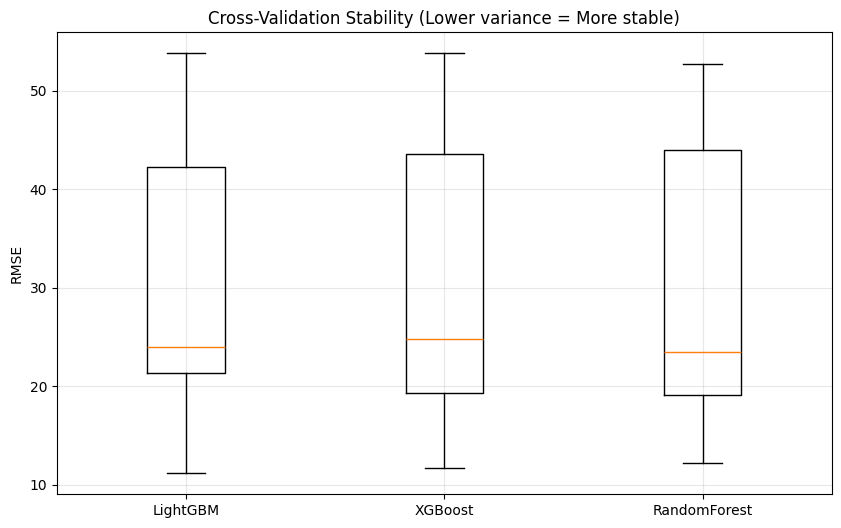


✅ Saved: cross_validation.png


In [76]:
# ========================================
# CROSS-VALIDATION ANALYSIS
# ========================================
print("\n" + "="*80)
print("CROSS-VALIDATION (Model Stability Check)")
print("="*80)

from sklearn.model_selection import TimeSeriesSplit

# Time Series Cross-Validation (5 folds)
tscv = TimeSeriesSplit(n_splits=5)

cv_results = {'LightGBM': [], 'XGBoost': [], 'RandomForest': []}

print("\nRunning 5-fold time series cross-validation...")
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_scaled)):
    print(f"  Fold {fold+1}/5...", end=" ")

    X_fold_train, X_fold_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

    # LightGBM
    lgb_cv = lgb.LGBMRegressor(n_estimators=200, learning_rate=0.05, random_state=42, verbose=-1)
    lgb_cv.fit(X_fold_train, y_fold_train)
    pred_cv = lgb_cv.predict(X_fold_val)
    cv_results['LightGBM'].append(np.sqrt(mean_squared_error(y_fold_val, pred_cv)))

    # XGBoost
    xgb_cv = xgb.XGBRegressor(n_estimators=200, learning_rate=0.05, random_state=42, verbosity=0)
    xgb_cv.fit(X_fold_train, y_fold_train)
    pred_cv = xgb_cv.predict(X_fold_val)
    cv_results['XGBoost'].append(np.sqrt(mean_squared_error(y_fold_val, pred_cv)))

    # Random Forest
    rf_cv = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1, verbose=0)
    rf_cv.fit(X_fold_train, y_fold_train)
    pred_cv = rf_cv.predict(X_fold_val)
    cv_results['RandomForest'].append(np.sqrt(mean_squared_error(y_fold_val, pred_cv)))

    print("Done")

print("\nCross-Validation Results (RMSE):")
for model_name, scores in cv_results.items():
    print(f"  {model_name}: {np.mean(scores):.2f} ± {np.std(scores):.2f}")

# Visualization
plt.figure(figsize=(10, 6))
plt.boxplot(cv_results.values(), labels=cv_results.keys())
plt.ylabel('RMSE')
plt.title('Cross-Validation Stability (Lower variance = More stable)')
plt.grid(alpha=0.3)
plt.savefig('cross_validation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Saved: cross_validation.png")


[FEATURE IMPORTANCE]


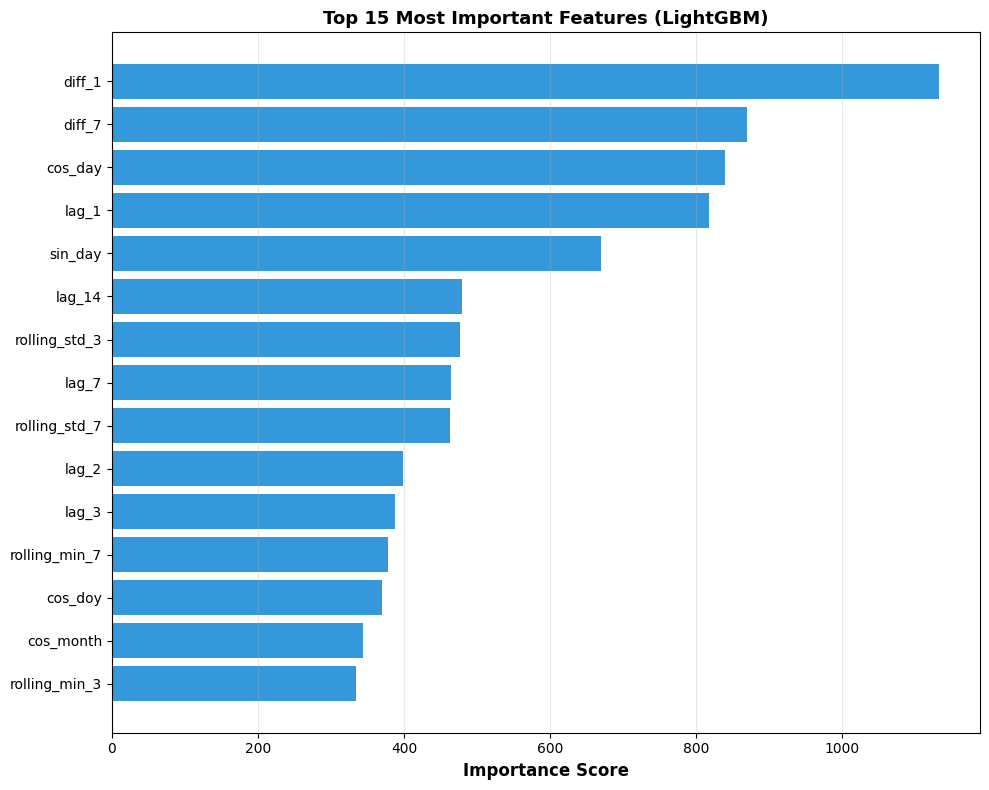

✅ Saved: feature_importance.png

Top 10 Features:
  1. diff_1: 1132.0000
  2. diff_7: 870.0000
  3. cos_day: 840.0000
  4. lag_1: 818.0000
  5. sin_day: 670.0000
  6. lag_14: 480.0000
  7. rolling_std_3: 476.0000
  8. lag_7: 465.0000
  9. rolling_std_7: 463.0000
  10. lag_2: 398.0000


In [77]:
# ========================================
# FEATURE IMPORTANCE ANALYSIS
# ========================================
print("\n[FEATURE IMPORTANCE]")

# Get feature importance from LightGBM (best tree model)
feature_importance = lgb_model.feature_importances_
feature_names = feature_cols

# Sort by importance
indices = np.argsort(feature_importance)[::-1][:15]  # Top 15

plt.figure(figsize=(10, 8))
plt.barh(range(15), feature_importance[indices], color='#3498db')
plt.yticks(range(15), [feature_names[i] for i in indices])
plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
plt.title('Top 15 Most Important Features (LightGBM)', fontsize=13, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: feature_importance.png")

# Print top 10
print("\nTop 10 Features:")
for i in range(10):
    idx = indices[i]
    print(f"  {i+1}. {feature_names[idx]}: {feature_importance[idx]:.4f}")


FINAL RESULTS - ALL METRICS

       Model       RMSE       MAE       MAPE        R²     PBIAS   Recall  Precision  F1-Score
       ARIMA 100.858075 88.293619 162.596631 -0.333877 47.093749 0.000000   0.000000  0.000000
    LightGBM  21.380194  9.239945   9.049802  0.940060  0.539432 0.958333   0.851852  0.901961
     XGBoost  26.969484 10.625695   7.570028  0.904624  4.386547 0.958333   0.657143  0.779661
RandomForest  22.514784  9.226380   7.113060  0.933529  3.341421 1.000000   0.727273  0.842105
        LSTM  19.023786 14.808267  22.035214  0.952544  2.179749 0.875000   0.913043  0.893617
 Transformer  25.145528 19.302115  30.111381  0.917088  3.712959 0.916667   1.000000  0.956522

✅ Results saved to 'model_comparison_results.csv'


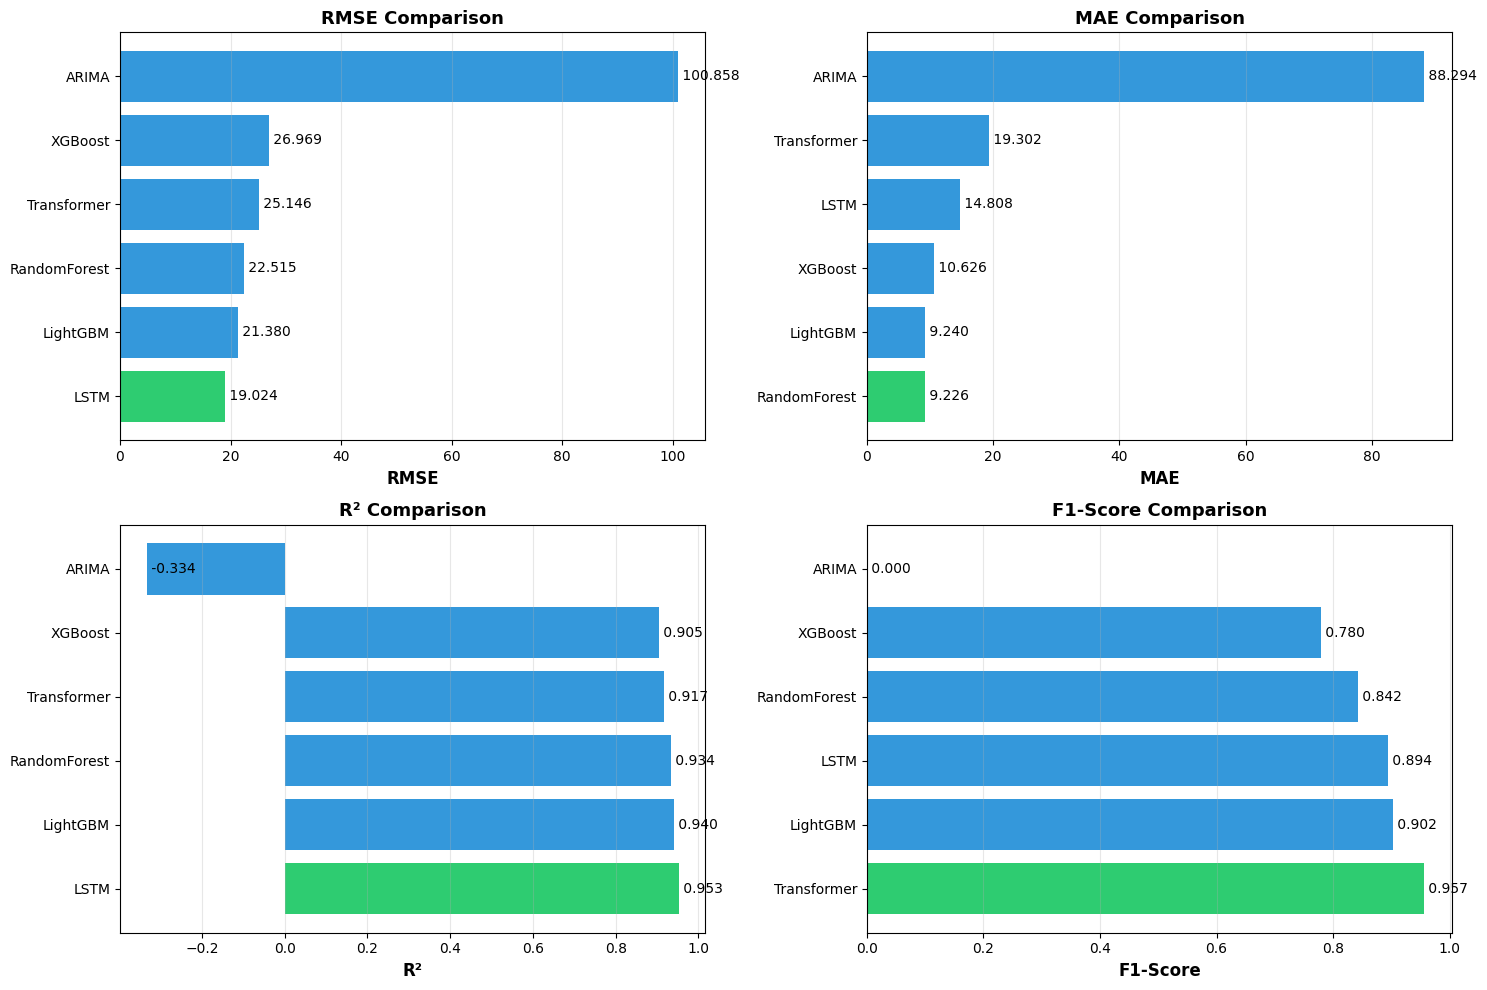


✅ Saved: model_comparison.png


In [78]:
# ========================================
# FINAL RESULTS
# ========================================
print("\n" + "="*80)
print("FINAL RESULTS - ALL METRICS")
print("="*80)

results_df = pd.DataFrame(results)
print("\n" + results_df.to_string(index=False))

# Save results
results_df.to_csv('model_comparison_results.csv', index=False)
print("\n✅ Results saved to 'model_comparison_results.csv'")

# ========================================
# VISUALIZATION 1: Metrics Comparison
# ========================================
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics_to_plot = ['RMSE', 'MAE', 'R²', 'F1-Score']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx//2, idx%2]

    # Sort by metric
    if metric in ['R²', 'F1-Score', 'Precision', 'Recall']:
        data = results_df.sort_values(metric, ascending=False)  # Higher is better
    else:
        data = results_df.sort_values(metric, ascending=True)  # Lower is better

    colors = ['#2ecc71' if i == 0 else '#3498db' for i in range(len(data))]
    bars = ax.barh(data['Model'], data[metric], color=colors)

    ax.set_xlabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontsize=13, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

    # Add values
    for i, (bar, val) in enumerate(zip(bars, data[metric])):
        ax.text(val, i, f' {val:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Saved: model_comparison.png")

In [79]:
# ========================================
# STATISTICAL SIGNIFICANCE TESTING
# ========================================
print("\n[STATISTICAL SIGNIFICANCE]")

from scipy.stats import wilcoxon

# Compare errors between models
errors = {}
for name, preds in predictions.items():
    errors[name] = np.abs(y_test - preds)

# Find best model by RMSE
best_model = results_df.loc[results_df['RMSE'].idxmin(), 'Model']
print(f"\nComparing all models against best performer: {best_model}")

for name in predictions.keys():
    if name != best_model:
        statistic, p_value = wilcoxon(errors[best_model], errors[name])

        if p_value < 0.05:
            print(f"  {name} vs {best_model}: p={p_value:.4f} *** SIGNIFICANT")
        else:
            print(f"  {name} vs {best_model}: p={p_value:.4f} (Not significant)")

print("\n*** = Difference is statistically significant (p < 0.05)")


[STATISTICAL SIGNIFICANCE]

Comparing all models against best performer: LSTM
  ARIMA vs LSTM: p=0.0000 *** SIGNIFICANT
  LightGBM vs LSTM: p=0.0000 *** SIGNIFICANT
  XGBoost vs LSTM: p=0.0000 *** SIGNIFICANT
  RandomForest vs LSTM: p=0.0000 *** SIGNIFICANT
  Transformer vs LSTM: p=0.0000 *** SIGNIFICANT

*** = Difference is statistically significant (p < 0.05)


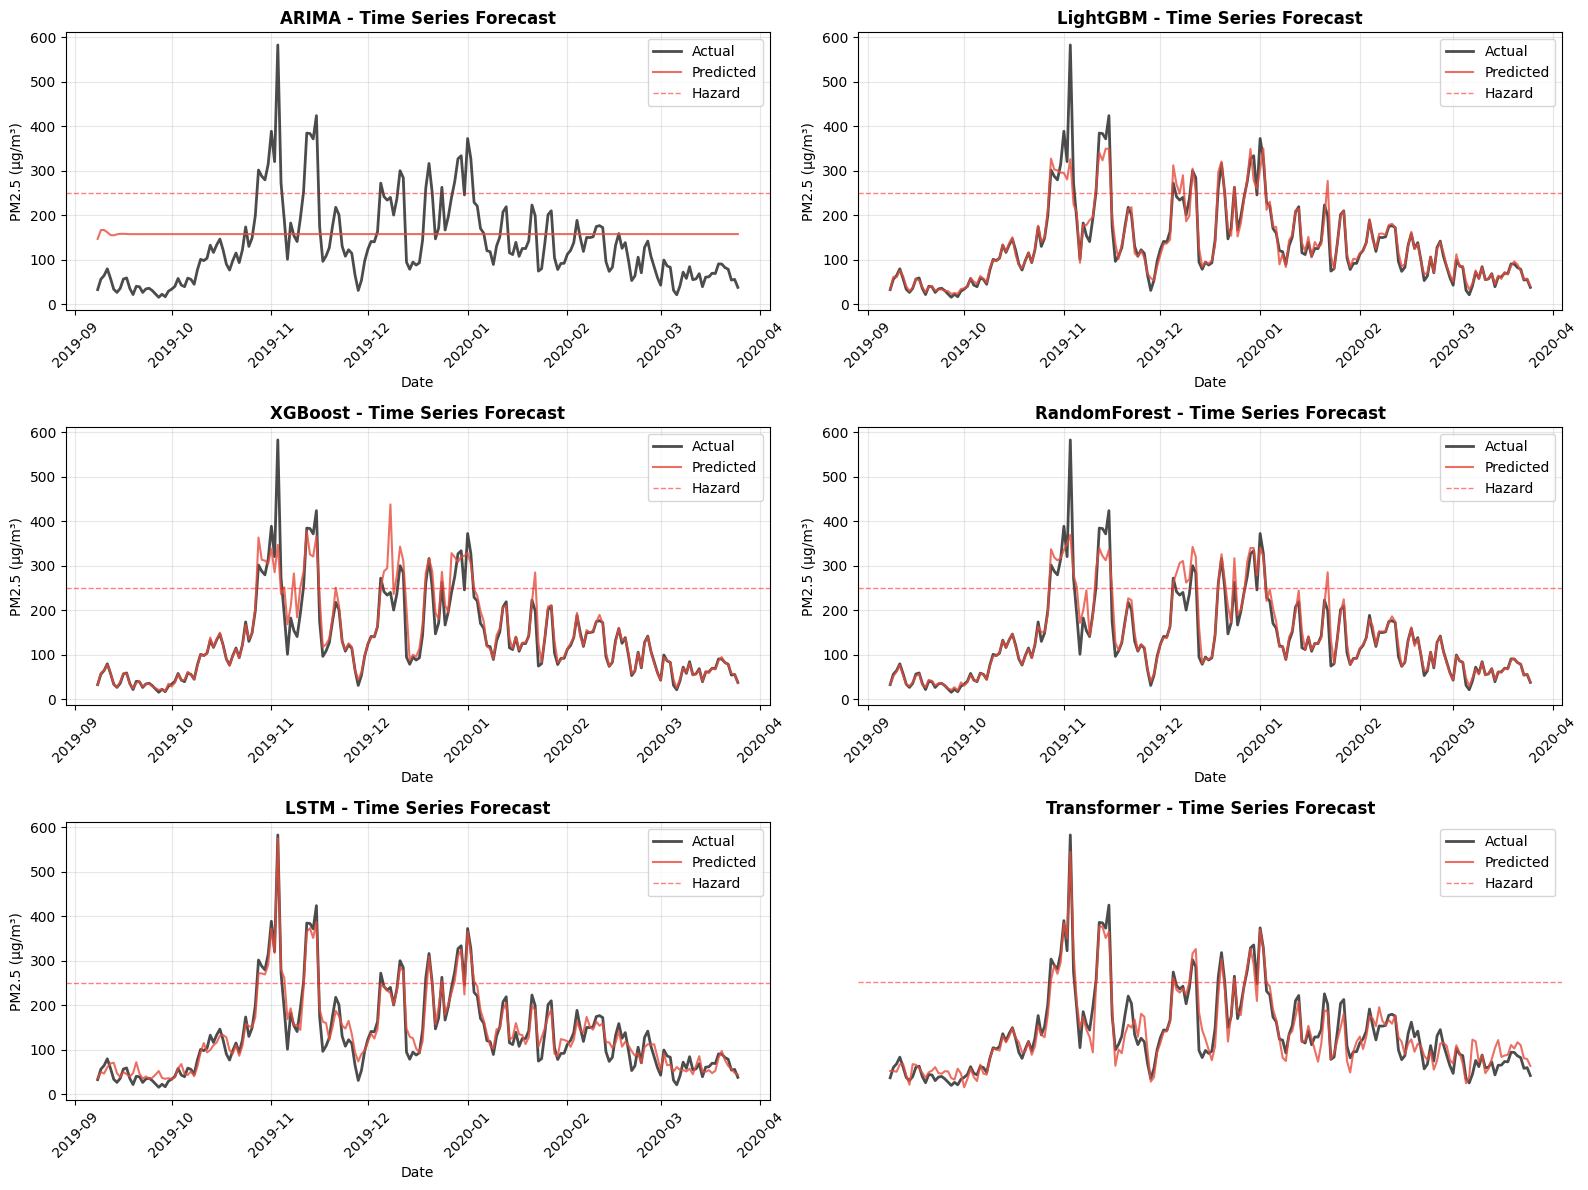

✅ Saved: time_series_predictions.png


In [80]:
# ========================================
# VISUALIZATION 2: Time Series Predictions
# ========================================
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (name, preds) in enumerate(predictions.items()):
    ax = axes[idx]

    # Plot first 200 days for clarity
    plot_range = slice(0, min(200, len(y_test)))

    ax.plot(dates_test[plot_range], y_test[plot_range],
            label='Actual', color='black', linewidth=2, alpha=0.7)
    ax.plot(dates_test[plot_range], preds[plot_range],
            label='Predicted', color='#e74c3c', linewidth=1.5, alpha=0.8)
    ax.axhline(y=250, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Hazard')

    ax.set_title(f'{name} - Time Series Forecast', fontsize=12, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('PM2.5 (µg/m³)')
    ax.legend(loc='upper right')
    ax.grid(alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

axes[-1].axis('off')  # Hide last empty subplot

plt.tight_layout()
plt.savefig('time_series_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: time_series_predictions.png")


[CONFUSION MATRICES]


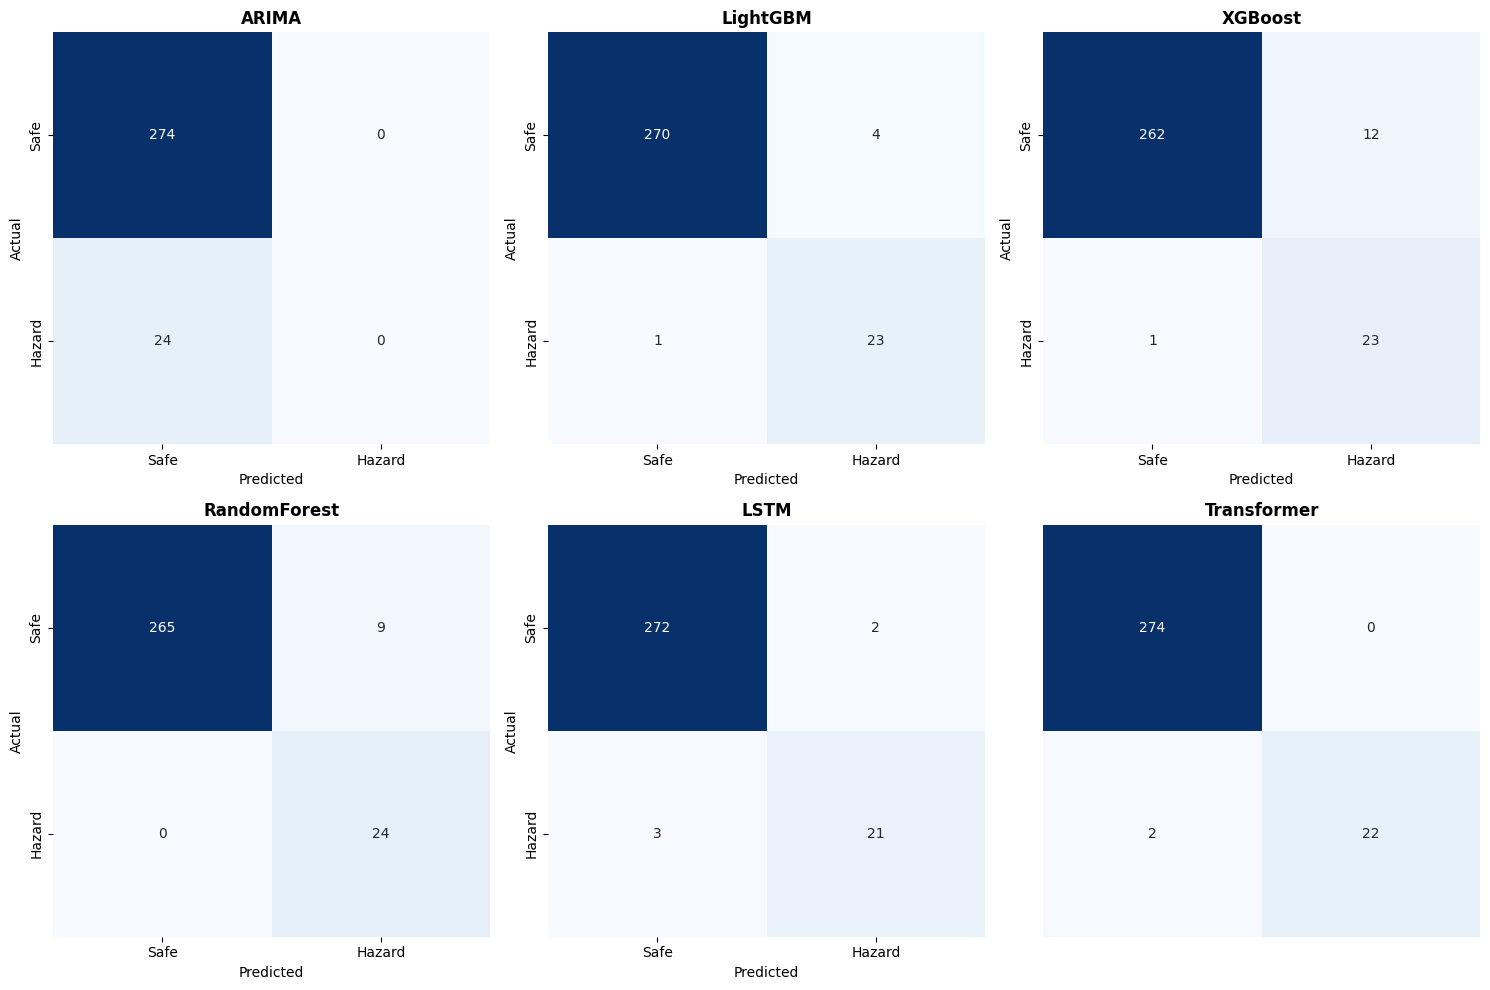

✅ Saved: confusion_matrices.png


In [81]:
# ========================================
# VISUALIZATION 3: Confusion Matrices
# ========================================
print("\n[CONFUSION MATRICES]")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (name, preds) in enumerate(predictions.items()):
    HAZARD_THRESHOLD = 250
    y_true_binary = (y_test > HAZARD_THRESHOLD).astype(int)
    y_pred_binary = (preds > HAZARD_THRESHOLD).astype(int)

    cm = confusion_matrix(y_true_binary, y_pred_binary)

    ax = axes[idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(f'{name}', fontsize=12, fontweight='bold')
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_xticklabels(['Safe', 'Hazard'])
    ax.set_yticklabels(['Safe', 'Hazard'])

axes[-1].axis('off')  # Hide last empty subplot

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: confusion_matrices.png")

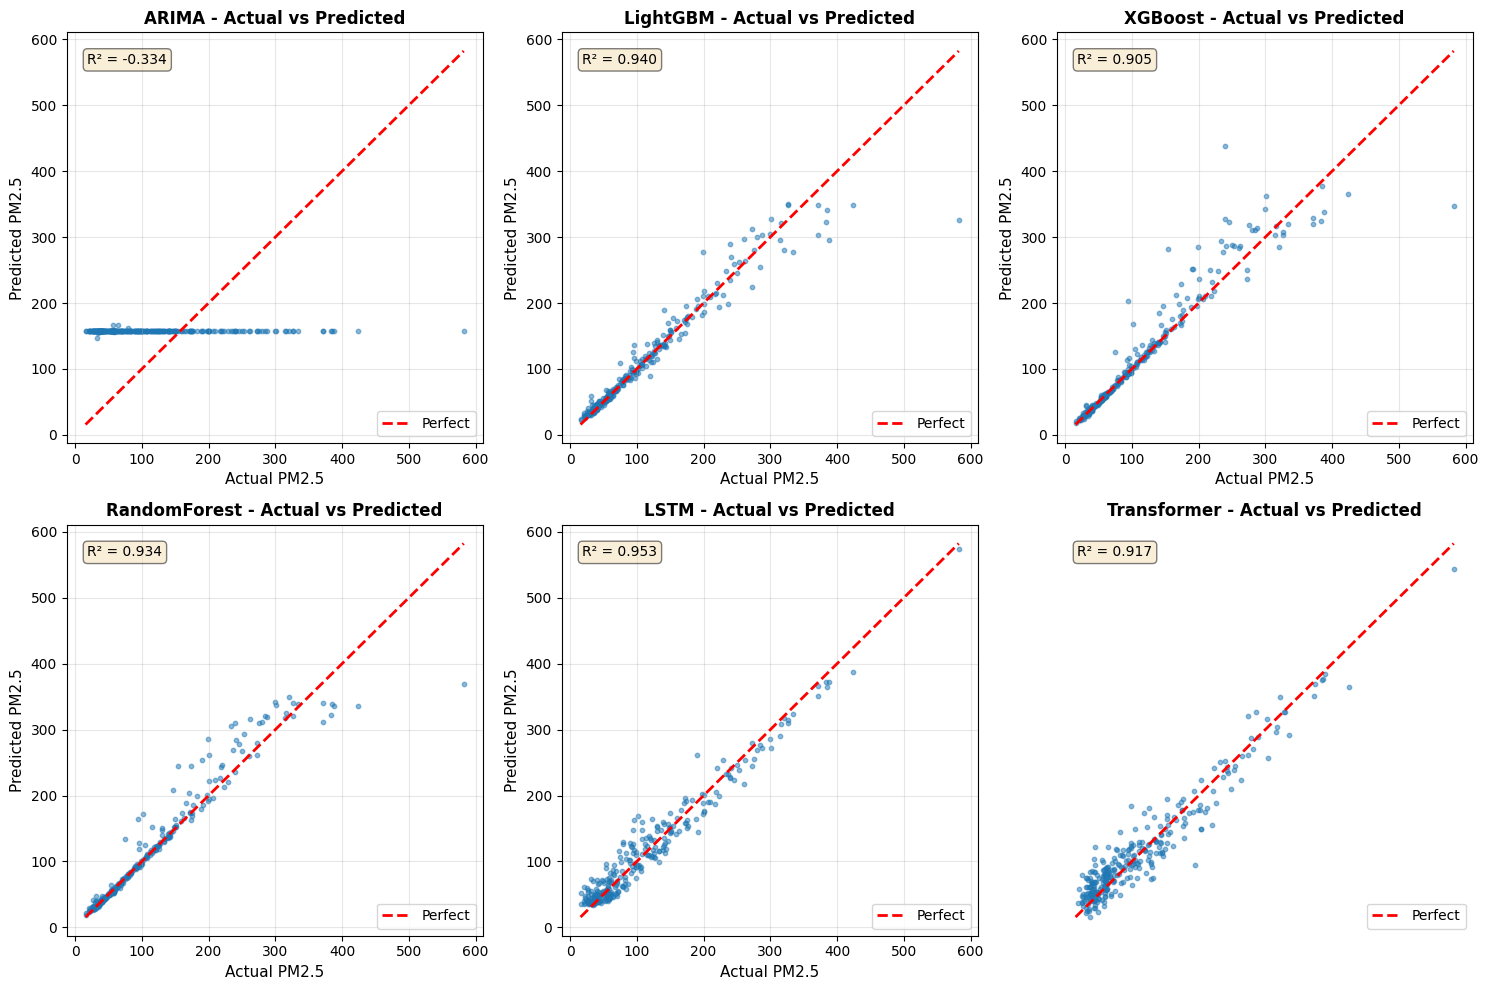

✅ Saved: actual_vs_predicted.png


In [82]:
# ========================================
# VISUALIZATION 4: Actual vs Predicted
# ========================================
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (name, preds) in enumerate(predictions.items()):
    ax = axes[idx]

    ax.scatter(y_test, preds, alpha=0.5, s=10)

    # Perfect prediction line
    min_val = min(y_test.min(), preds.min())
    max_val = max(y_test.max(), preds.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect')

    ax.set_xlabel('Actual PM2.5', fontsize=11)
    ax.set_ylabel('Predicted PM2.5', fontsize=11)
    ax.set_title(f'{name} - Actual vs Predicted', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)

    # Add R² score
    r2 = r2_score(y_test, preds)
    ax.text(0.05, 0.95, f'R² = {r2:.3f}', transform=ax.transAxes,
            fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

axes[-1].axis('off')

plt.tight_layout()
plt.savefig('actual_vs_predicted.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: actual_vs_predicted.png")

In [83]:
# ========================================
# FINAL SUMMARY
# ========================================
print("\n" + "="*80)
print("✅ PIPELINE COMPLETE - ALL MODELS EVALUATED")
print("="*80)

print("\n📊 FILES GENERATED:")
print("   1. model_comparison_results.csv")
print("   2. model_comparison.png")
print("   3. time_series_predictions.png")
print("   4. confusion_matrices.png")
print("   5. actual_vs_predicted.png")

print("\n🏆 BEST MODEL BY METRIC:")
print(f"   Best RMSE: {results_df.loc[results_df['RMSE'].idxmin(), 'Model']} ({results_df['RMSE'].min():.2f})")
print(f"   Best R²: {results_df.loc[results_df['R²'].idxmax(), 'Model']} ({results_df['R²'].max():.3f})")
print(f"   Best Recall: {results_df.loc[results_df['Recall'].idxmax(), 'Model']} ({results_df['Recall'].max():.3f})")
print(f"   Best F1-Score: {results_df.loc[results_df['F1-Score'].idxmax(), 'Model']} ({results_df['F1-Score'].max():.3f})")

print("\n" + "="*80)


✅ PIPELINE COMPLETE - ALL MODELS EVALUATED

📊 FILES GENERATED:
   1. model_comparison_results.csv
   2. model_comparison.png
   3. time_series_predictions.png
   4. confusion_matrices.png
   5. actual_vs_predicted.png

🏆 BEST MODEL BY METRIC:
   Best RMSE: LSTM (19.02)
   Best R²: LSTM (0.953)
   Best Recall: RandomForest (1.000)
   Best F1-Score: Transformer (0.957)




[RESIDUAL ANALYSIS]


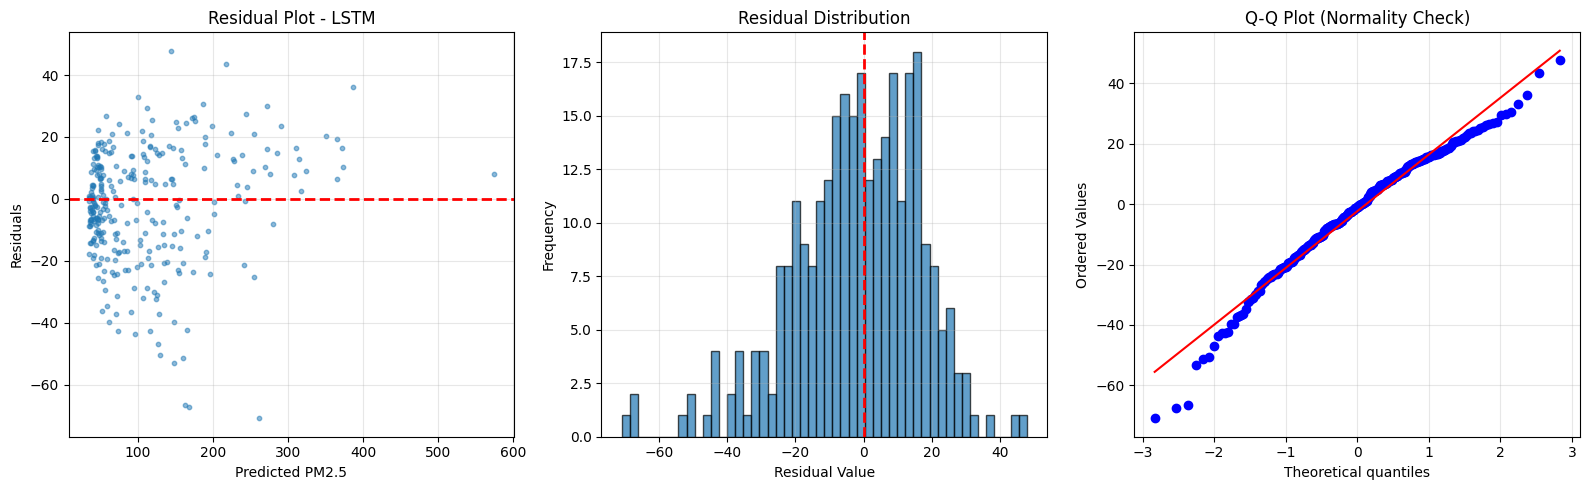

✅ Saved: residual_analysis.png

Residual Statistics:
  Mean: -2.34 (should be ~0)
  Std Dev: 18.88
  Min: -70.93
  Max: 47.88


In [84]:
# ========================================
# RESIDUAL ANALYSIS (Best Model)
# ========================================
print("\n[RESIDUAL ANALYSIS]")

best_model_name = results_df.loc[results_df['RMSE'].idxmin(), 'Model']
best_predictions = predictions[best_model_name]
residuals = y_test - best_predictions

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Residual Plot
axes[0].scatter(best_predictions, residuals, alpha=0.5, s=10)
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted PM2.5')
axes[0].set_ylabel('Residuals')
axes[0].set_title(f'Residual Plot - {best_model_name}')
axes[0].grid(alpha=0.3)

# 2. Residual Distribution
axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Residual Value')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Residual Distribution')
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1].grid(alpha=0.3)

# 3. Q-Q Plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot (Normality Check)')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('residual_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Saved: residual_analysis.png")
print(f"\nResidual Statistics:")
print(f"  Mean: {np.mean(residuals):.2f} (should be ~0)")
print(f"  Std Dev: {np.std(residuals):.2f}")
print(f"  Min: {np.min(residuals):.2f}")
print(f"  Max: {np.max(residuals):.2f}")


[SEASONAL PERFORMANCE]

LSTM - RMSE by Season:
  Winter: 20.41
  Spring: 13.79
  Summer: 10.60
  Autumn: 24.14


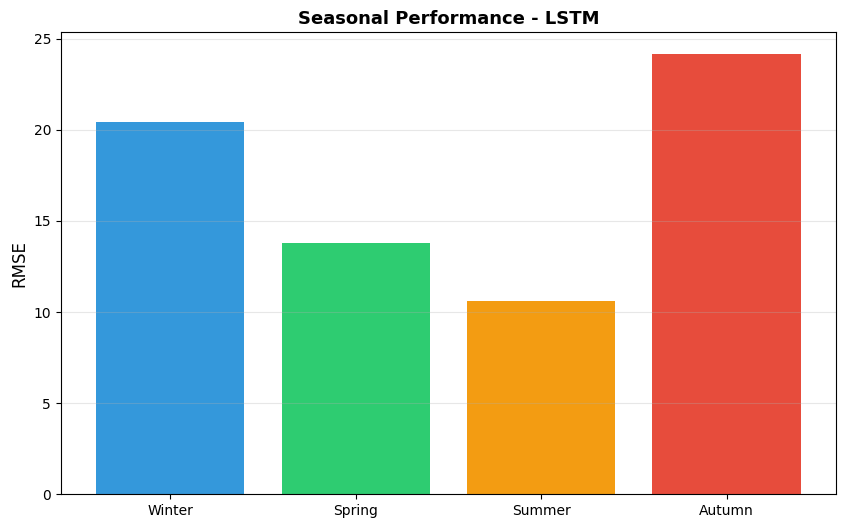

✅ Saved: seasonal_performance.png


In [85]:
# ========================================
# SEASONAL PERFORMANCE ANALYSIS
# ========================================
print("\n[SEASONAL PERFORMANCE]")

# Add season info
test_months = pd.DatetimeIndex(dates_test).month
seasons = []
for month in test_months:
    if month in [12, 1, 2]:
        seasons.append('Winter')
    elif month in [3, 4, 5]:
        seasons.append('Spring')
    elif month in [6, 7, 8]:
        seasons.append('Summer')
    else:
        seasons.append('Autumn')

seasons = np.array(seasons)

# Calculate RMSE by season for best model
best_preds = predictions[best_model_name]

seasonal_rmse = {}
for season in ['Winter', 'Spring', 'Summer', 'Autumn']:
    mask = (seasons == season)
    if mask.sum() > 0:
        rmse = np.sqrt(mean_squared_error(y_test[mask], best_preds[mask]))
        seasonal_rmse[season] = rmse

print(f"\n{best_model_name} - RMSE by Season:")
for season, rmse in seasonal_rmse.items():
    print(f"  {season}: {rmse:.2f}")

# Plot
plt.figure(figsize=(10, 6))
plt.bar(seasonal_rmse.keys(), seasonal_rmse.values(), color=['#3498db', '#2ecc71', '#f39c12', '#e74c3c'])
plt.ylabel('RMSE', fontsize=12)
plt.title(f'Seasonal Performance - {best_model_name}', fontsize=13, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.savefig('seasonal_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: seasonal_performance.png")